In [1]:
import zipfile, pathlib
import pandas as pd

In [2]:
# !pip install kaggle

In [3]:
# !kaggle competitions download -c house-prices-advanced-regression-techniques -p data

In [4]:
# pathlib.Path("data/house_prices").mkdir(exist_ok=True)

# with zipfile.ZipFile("data/house-prices-advanced-regression-techniques.zip", "r") as z:
#     z.extractall("data/house_prices")

In [5]:
train = pd.read_csv("data/house_prices/train.csv")
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## EDA

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

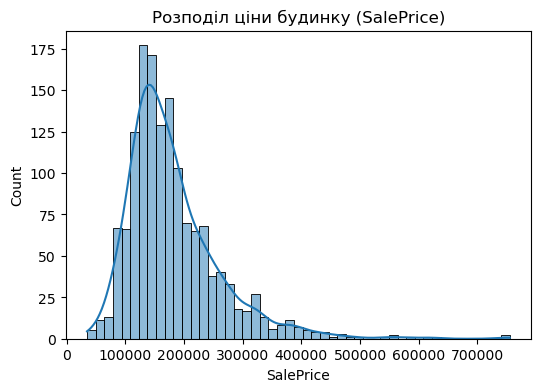

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice"], kde=True)
plt.title("Розподіл ціни будинку (SalePrice)")
plt.show()

In [8]:
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Кількість пропусків у кожній колонці:")
print(missing.head(20))

Кількість пропусків у кожній колонці:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


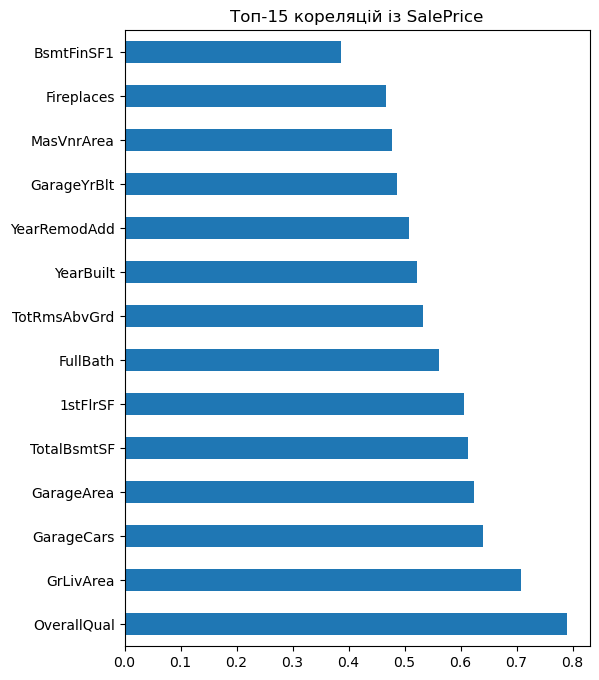

In [9]:
numeric_cols = train.select_dtypes(include=['int64','float64']).columns
corr = train[numeric_cols].corr()
plt.figure(figsize=(6,8))
corr["SalePrice"].sort_values(ascending=False).head(15).iloc[1:].plot(kind="barh")
plt.title("Топ-15 кореляцій із SalePrice")
plt.show()

## Preprocessing

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [11]:
X = train.drop(columns=["SalePrice", "Id"])
y = train["SalePrice"]

numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1022, 79)
Test shape: (438, 79)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [14]:
# створюємо пайплайн: предобробка + модель
linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# тренування
linreg_pipeline.fit(X_train, y_train)
y_pred_linreg = linreg_pipeline.predict(X_test)

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
mae = mean_absolute_error(y_test, y_pred_linreg)
r2 = r2_score(y_test, y_pred_linreg)
print("Linear Regression (Scikit-learn)")
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

Linear Regression (Scikit-learn)
RMSE: 27940.44387138569
MAE: 18209.370677045466
R2: 0.8881258362993147


In [16]:
from sklearn.linear_model import LassoCV, ElasticNetCV

In [17]:
# Lasso з крос-валідацією для підбору alpha
lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)
y_pred_lasso = lasso_pipeline.predict(X_test)

print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("Lasso R2:", r2_score(y_test, y_pred_lasso))

Lasso RMSE: 28329.704162470214
Lasso R2: 0.8849869082548628


In [18]:
enet_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ElasticNetCV(cv=5, random_state=42))
])

enet_pipeline.fit(X_train, y_train)
y_pred_enet = enet_pipeline.predict(X_test)

print("ElasticNet RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_enet)))
print("ElasticNet R2:", r2_score(y_test, y_pred_enet))

ElasticNet RMSE: 76390.69844804806
ElasticNet R2: 0.16373453706716845


# SciKit learn

### 6.1 LinearRegression (Scikit-Learn)

In [19]:
import time
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
def evaluate_regressor(model, X_train, y_train, X_test, y_test, name="Model"):
    """
    Обчислює RMSE, MAE, R^2 на train і test, а також час навчання/інференсу.
    Повертає словник з метриками (зручно для зведеної таблиці пізніше).
    """
    t0 = time.time()                                   # старт таймера навчання
    model.fit(X_train, y_train)                        # навчання моделі
    t1 = time.time()                                   # час закінчення навчання

    # передбачення на train
    y_pred_tr = model.predict(X_train)
    # передбачення на test
    y_pred_te = model.predict(X_test)

    # обчислення метрик
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
    mae_tr  = mean_absolute_error(y_train, y_pred_tr)
    r2_tr   = r2_score(y_train, y_pred_tr)

    rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
    mae_te  = mean_absolute_error(y_test, y_pred_te)
    r2_te   = r2_score(y_test, y_pred_te)

    t2 = time.time()                                   # кінець усього блоку
    train_time = t1 - t0                               # час навчання
    infer_time = t2 - t1                               # час передбачення (обидві вибірки)

    # вивід результатів у зручному форматі
    print(f"\n{name}")
    print("-"*len(name))
    print(f"Train  -> RMSE: {rmse_tr:.2f} | MAE: {mae_tr:.2f} | R^2: {r2_tr:.4f}")
    print(f"Test   -> RMSE: {rmse_te:.2f} | MAE: {mae_te:.2f} | R^2: {r2_te:.4f}")
    print(f"Time   -> fit: {train_time:.3f}s | predict: {infer_time:.3f}s")

    return {
        "model": name,
        "rmse_train": rmse_tr, "mae_train": mae_tr, "r2_train": r2_tr,
        "rmse_test": rmse_te, "mae_test": mae_te, "r2_test": r2_te,
        "fit_time_s": train_time, "pred_time_s": infer_time
    }

In [21]:
# --- Пайплайн: предобробка + лінійна регресія ---
linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),   # наш ColumnTransformer: імпутація, масштабування, OHE
    ("regressor", LinearRegression()) # звичайна МНК-регресія без регуляризації
])

# --- Навчання та оцінка ---
linreg_results = evaluate_regressor(
    linreg_pipeline, X_train, y_train, X_test, y_test,
    name="LinearRegression (SKL)"
)


LinearRegression (SKL)
----------------------
Train  -> RMSE: 19597.55 | MAE: 12728.97 | R^2: 0.9362
Test   -> RMSE: 27940.44 | MAE: 18209.37 | R^2: 0.8881
Time   -> fit: 0.103s | predict: 0.043s


### 6.2.1 LassoCV (L1-регуляризація, автоматичний підбір α)

In [22]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
import numpy as np

In [23]:
# підберемо альфи на лог-шкалі
alphas = np.logspace(-4, 2, 50)

lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=20000))
])

lasso_results = evaluate_regressor(
    lasso_pipeline, X_train, y_train, X_test, y_test,
    name="LassoCV (SKL)"
)

# подивимось підібраний alpha
best_alpha_lasso = lasso_pipeline.named_steps["regressor"].alpha_
print(f"Best alpha (Lasso): {best_alpha_lasso:.6f}")



LassoCV (SKL)
-------------
Train  -> RMSE: 22126.04 | MAE: 14268.86 | R^2: 0.9187
Test   -> RMSE: 26701.42 | MAE: 17056.64 | R^2: 0.8978
Time   -> fit: 20.186s | predict: 0.025s
Best alpha (Lasso): 100.000000


### 6.2.2 ElasticNetCV (L1+L2, підбір α та l1_ratio)

In [24]:
from sklearn.linear_model import ElasticNetCV

In [25]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
alphas_en = np.logspace(-4, 2, 40)

enet_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", ElasticNetCV(
        l1_ratio=l1_ratios,
        alphas=alphas_en,
        cv=5,
        random_state=42,
        max_iter=20000
    ))
])

enet_results = evaluate_regressor(
    enet_pipeline, X_train, y_train, X_test, y_test,
    name="ElasticNetCV (SKL)"
)


D:\study\programming\conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94291688793.06982, tolerance: 474197795.0469259
  model = cd_fast.sparse_enet_coordinate_descent(
D:\study\programming\conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159743145163.47794, tolerance: 474197795.0469259
  model = cd_fast.sparse_enet_coordinate_descent(
D:\study\programming\conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162350779298.2174, tolerance: 474197795.0469259
  model = cd_fast.sparse_enet_coordinate_descent(
D:\study\programming\conda\Lib\site-packages\sklearn\linear_model\_coordinate_des


ElasticNetCV (SKL)
------------------
Train  -> RMSE: 21610.43 | MAE: 14198.35 | R^2: 0.9224
Test   -> RMSE: 28655.92 | MAE: 19048.43 | R^2: 0.8823
Time   -> fit: 1420.700s | predict: 0.036s


In [26]:
best_alpha_en = enet_pipeline.named_steps["regressor"].alpha_
best_l1_ratio = enet_pipeline.named_steps["regressor"].l1_ratio_
print(f"Best alpha (ElasticNet): {best_alpha_en:.6f}, best l1_ratio: {best_l1_ratio}")

Best alpha (ElasticNet): 0.001701, best l1_ratio: 0.3


In [27]:
results_list = []
# якщо ти вже маєш linreg_results з 6.1:
results_list.append(linreg_results)
results_list.append(lasso_results)
results_list.append(enet_results)

results_df = (pd.DataFrame(results_list)
              .sort_values("rmse_test")
              .reset_index(drop=True))
results_df

,model,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test,fit_time_s,pred_time_s
0,LassoCV (SKL),22126.044644,14268.859537,0.918658,26701.419272,17056.638813,0.897828,20.185926,0.025413
1,LinearRegression (SKL),19597.553179,12728.966957,0.936187,27940.443871,18209.370677,0.888126,0.102864,0.042881
2,ElasticNetCV (SKL),21610.428210,14198.350500,0.922405,28655.923417,19048.429500,0.882323,1420.699901,0.035503


6.2.4

Best by Test RMSE: LassoCV (SKL)


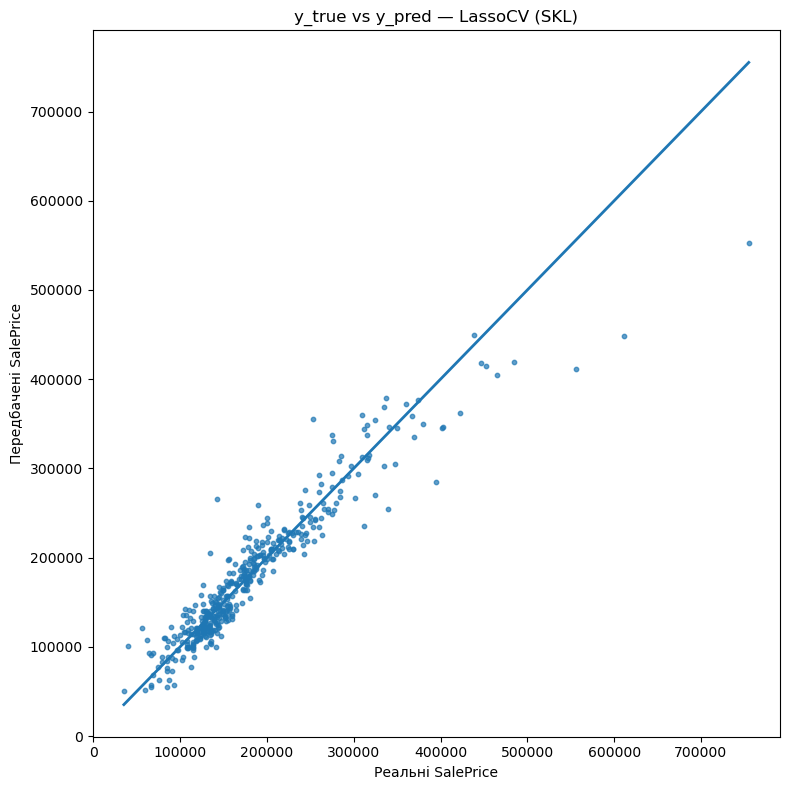

In [28]:
# Визначимо, яка з трьох має найменший Test RMSE
best_row = results_df.iloc[0]
best_name = best_row["model"]
print("Best by Test RMSE:", best_name)

# беремо відповідний пайплайн
name_to_model = {
    "LinearRegression (SKL)": linreg_pipeline,
    "LassoCV (SKL)": lasso_pipeline,
    "ElasticNetCV (SKL)": enet_pipeline
}
best_model = name_to_model[best_name]

# передбачення та графік
y_pred_best = best_model.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_best, s=10, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2)
plt.xlabel("Реальні SalePrice")
plt.ylabel("Передбачені SalePrice")
plt.title(f"y_true vs y_pred — {best_name}")
plt.tight_layout(); plt.show()


#### XGBoost

In [29]:
!pip install xgboost

In [30]:
!pip install --upgrade xgboost


In [31]:
from xgboost import XGBRegressor

In [32]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=1200,       # достатньо велике, але не “до неба”
        learning_rate=0.03,      # повільніше — стабільніше
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"       # швидше на сучасних версіях
    ))
])

xgb_results = evaluate_regressor(
    xgb_pipeline, X_train, y_train, X_test, y_test,
    name="XGBRegressor (pipeline)"
)


XGBRegressor (pipeline)
-----------------------
Train  -> RMSE: 3425.94 | MAE: 2564.61 | R^2: 0.9980
Test   -> RMSE: 23688.16 | MAE: 14815.12 | R^2: 0.9196
Time   -> fit: 1.083s | predict: 0.063s


In [33]:
results_list.append(xgb_results)
results_df = (pd.DataFrame(results_list)
              .sort_values("rmse_test")
              .reset_index(drop=True))
results_df


,model,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test,fit_time_s,pred_time_s
0,XGBRegressor (pipeline),3425.941330,2564.612305,0.998050,23688.160756,14815.117188,0.919587,1.083185,0.062561
1,LassoCV (SKL),22126.044644,14268.859537,0.918658,26701.419272,17056.638813,0.897828,20.185926,0.025413
2,LinearRegression (SKL),19597.553179,12728.966957,0.936187,27940.443871,18209.370677,0.888126,0.102864,0.042881
3,ElasticNetCV (SKL),21610.428210,14198.350500,0.922405,28655.923417,19048.429500,0.882323,1420.699901,0.035503


---

In [41]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [42]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

In [43]:
preprocessor_es = preprocessor.fit(X_tr, y_tr)
X_tr_t   = preprocessor_es.transform(X_tr)
X_val_t  = preprocessor_es.transform(X_val)
X_test_t = preprocessor_es.transform(X_test)

In [44]:
xgb_params = dict(
    n_estimators=5000,      # великий максимум — зупинимо рано
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

In [45]:
def train_xgb_with_es(X_tr_t, y_tr, X_val_t, y_val, X_test_t, params, es_rounds=100):
    """
    Повертає: dict з метриками та (best_iter, fit_time), працює як із новими, так і зі старими версіями xgboost.
    """
    # Спроба через SKL API (нові версії)
    try:
        model = XGBRegressor(**params)
        t0 = time.time()
        model.fit(
            X_tr_t, y_tr,
            eval_set=[(X_val_t, y_val)],
            early_stopping_rounds=es_rounds,
            verbose=False
        )
        fit_time = time.time() - t0
        best_iter = getattr(model, "best_iteration", None)

        # передбачення (з урахуванням best_iteration, якщо він є)
        if best_iter is not None:
            y_pred_tr = model.predict(X_tr_t,  iteration_range=(0, best_iter+1))
            y_pred_te = model.predict(X_test_t, iteration_range=(0, best_iter+1))
        else:
            y_pred_tr = model.predict(X_tr_t)
            y_pred_te = model.predict(X_test_t)

        return model, best_iter, fit_time, y_pred_tr, y_pred_te

    except TypeError:
        # Фолбек для старих версій: використовуємо низькорівневий xgb.train
        dtrain = xgb.DMatrix(X_tr_t, label=y_tr)
        dval   = xgb.DMatrix(X_val_t, label=y_val)
        dtest  = xgb.DMatrix(X_test_t, label=y_test)

        train_params = {
            "objective": "reg:squarederror",
            "eta": params.get("learning_rate", 0.01),
            "max_depth": params.get("max_depth", 4),
            "subsample": params.get("subsample", 0.9),
            "colsample_bytree": params.get("colsample_bytree", 0.9),
            "seed": params.get("random_state", 42),
            "tree_method": params.get("tree_method", "hist")
        }

        evallist = [(dtrain, 'train'), (dval, 'eval')]
        t0 = time.time()
        booster = xgb.train(
            train_params,
            dtrain,
            num_boost_round=params.get("n_estimators", 5000),
            evals=evallist,
            early_stopping_rounds=es_rounds,
            verbose_eval=False
        )
        fit_time = time.time() - t0
        best_iter = booster.best_iteration

        # передбачення на кращій ітерації
        y_pred_tr = booster.predict(dtrain, iteration_range=(0, best_iter+1))
        y_pred_te = booster.predict(dtest,  iteration_range=(0, best_iter+1))

        return booster, best_iter, fit_time, y_pred_tr, y_pred_te

In [46]:
# 4) Тренуємо та рахуємо метрики
model_es, best_iter, fit_time = None, None, None
model_es, best_iter, fit_time, y_pred_tr, y_pred_te = train_xgb_with_es(
    X_tr_t, y_tr, X_val_t, y_val, X_test_t, xgb_params, es_rounds=100
)

rmse_tr = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
mae_tr  = mean_absolute_error(y_tr, y_pred_tr)
r2_tr   = r2_score(y_tr, y_pred_tr)

rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
mae_te  = mean_absolute_error(y_test, y_pred_te)
r2_te   = r2_score(y_test, y_pred_te)

print("\nXGBRegressor — early stopping (версійно-стійкий)")
print("-------------------------------------------------")
print(f"Train  -> RMSE: {rmse_tr:.2f} | MAE: {mae_tr:.2f} | R^2: {r2_tr:.4f}")
print(f"Test   -> RMSE: {rmse_te:.2f} | MAE: {mae_te:.2f} | R^2: {r2_te:.4f}")
print(f"Best iteration: {best_iter}")
print(f"Fit time: {fit_time:.2f}s")


XGBRegressor — early stopping (версійно-стійкий)
-------------------------------------------------
Train  -> RMSE: 11230.52 | MAE: 8323.66 | R^2: 0.9786
Test   -> RMSE: 25785.15 | MAE: 16418.50 | R^2: 0.9047
Best iteration: 682
Fit time: 0.56s


In [47]:
results_list.append({
    "model": "XGBRegressor (early stop, compat)",
    "rmse_train": rmse_tr, "mae_train": mae_tr, "r2_train": r2_tr,
    "rmse_test": rmse_te,  "mae_test": mae_te,  "r2_test": r2_te,
    "fit_time_s": fit_time, "pred_time_s": np.nan
})
results_df = (pd.DataFrame(results_list)
              .sort_values("rmse_test")
              .reset_index(drop=True))
results_df

,model,rmse_train,mae_train,r2_train,rmse_test,mae_test,r2_test,fit_time_s,pred_time_s
0,XGBRegressor (pipeline),3425.941330,2564.612305,0.998050,23688.160756,14815.117188,0.919587,1.083185,0.062561
1,"XGBRegressor (early stop, compat)",11230.518777,8323.659180,0.978644,25785.152937,16418.501953,0.904720,0.563345,NaN
2,LassoCV (SKL),22126.044644,14268.859537,0.918658,26701.419272,17056.638813,0.897828,20.185926,0.025413
3,LinearRegression (SKL),19597.553179,12728.966957,0.936187,27940.443871,18209.370677,0.888126,0.102864,0.042881
4,ElasticNetCV (SKL),21610.428210,14198.350500,0.922405,28655.923417,19048.429500,0.882323,1420.699901,0.035503


#### Vanilla Python (Numpy/Pandas)